In [5]:
# =============================================================================
# 🚚 SYSTÈME PROFESSIONNEL DE LIVRAISON INTELLIGENTE - TUNISIE
# =============================================================================
# Optimisation VRP/TSP avec routage routier réel (OSRM)
# Interface moderne avec carte interactive OpenStreetMap
# =============================================================================

import pandas as pd
import numpy as np
import folium
from folium import plugins
import json
import math
from itertools import permutations
from scipy.spatial.distance import cdist
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from IPython.display import display, HTML, IFrame
import warnings
warnings.filterwarnings('ignore')

print("✅ Modules chargés avec succès")
print("📦 Google OR-Tools pour l'optimisation VRP")
print("🗺️ Folium pour la cartographie OpenStreetMap")
print("📊 Pandas/NumPy pour le traitement des données")

✅ Modules chargés avec succès
📦 Google OR-Tools pour l'optimisation VRP
🗺️ Folium pour la cartographie OpenStreetMap
📊 Pandas/NumPy pour le traitement des données


In [6]:
# =============================================================================
# 📊 CHARGEMENT DES DONNÉES CLIENTS
# =============================================================================

# Charger les commandes clients
df_clients = pd.read_csv('orders_locations.csv')
df_clients.columns = ['order_id', 'lat', 'lon']

print(f"📍 {len(df_clients)} clients chargés depuis orders_locations.csv")
print(f"📍 Zone géographique: Sfax, Tunisie")
print(f"   Latitude: {df_clients['lat'].min():.4f} → {df_clients['lat'].max():.4f}")
print(f"   Longitude: {df_clients['lon'].min():.4f} → {df_clients['lon'].max():.4f}")
print()
df_clients.head(10)

📍 77 clients chargés depuis orders_locations.csv
📍 Zone géographique: Sfax, Tunisie
   Latitude: 34.8652 → 35.1020
   Longitude: 10.4842 → 10.7582



,order_id,lat,lon
0,ORDC01406,34.9766,10.5993
1,ORDZ10125,34.9770,10.5773
2,ORDZ04175,34.9551,10.6593
3,ORDI03691,34.9473,10.5616
4,ORDZ04094,34.9850,10.5533
5,ORDB10193,34.9299,10.6848
6,ORDI03630,34.9828,10.6131
7,ORDZ08573,34.9854,10.7081
8,ORDY05086,34.8988,10.5764
9,ORDX06045,34.9438,10.5738


In [3]:
# =============================================================================
# 🚗 CLASSE DE ROUTAGE OSRM LOCAL/FALLBACK
# =============================================================================
# Utilise OSRM local si disponible, sinon calcul géodésique optimisé

import requests
from math import radians, sin, cos, sqrt, atan2

class SmartRouter:
    """
    Moteur de routage intelligent avec fallback automatique.
    Priorité: OSRM local → OSRM public → Calcul géodésique
    """
    
    def __init__(self, osrm_url="http://localhost:5000"):
        self.osrm_url = osrm_url
        self.osrm_available = self._check_osrm()
        self.cache = {}
        
        if self.osrm_available:
            print(f"✅ OSRM local connecté: {osrm_url}")
        else:
            print("⚠️ OSRM local non disponible")
            print("📍 Mode: Calcul géodésique haute précision (Haversine)")
            print("💡 Pour activer OSRM local, exécutez:")
            print("   docker run -t -p 5000:5000 osrm/osrm-backend osrm-routed tunisia-latest.osrm")
    
    def _check_osrm(self):
        """Vérifie si OSRM est disponible"""
        try:
            r = requests.get(f"{self.osrm_url}/health", timeout=2)
            return r.status_code == 200
        except:
            try:
                # Test avec une requête de route simple
                r = requests.get(f"{self.osrm_url}/route/v1/driving/10.6,34.95;10.61,34.96", timeout=2)
                return r.status_code == 200
            except:
                return False
    
    def haversine_distance(self, lat1, lon1, lat2, lon2):
        """Calcul de distance géodésique (formule de Haversine)"""
        R = 6371  # Rayon de la Terre en km
        
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        
        return R * c
    
    def get_route(self, origin, destination):
        """
        Obtient la route entre deux points.
        Retourne: (distance_km, geometry_coords)
        """
        cache_key = f"{origin}_{destination}"
        if cache_key in self.cache:
            return self.cache[cache_key]
        
        lat1, lon1 = origin
        lat2, lon2 = destination
        
        if self.osrm_available:
            try:
                url = f"{self.osrm_url}/route/v1/driving/{lon1},{lat1};{lon2},{lat2}?overview=full&geometries=geojson"
                r = requests.get(url, timeout=5)
                data = r.json()
                
                if data.get('code') == 'Ok':
                    route = data['routes'][0]
                    distance = route['distance'] / 1000  # m → km
                    coords = [(p[1], p[0]) for p in route['geometry']['coordinates']]
                    result = (distance, coords)
                    self.cache[cache_key] = result
                    return result
            except:
                pass
        
        # Fallback: calcul géodésique avec facteur de correction routière
        straight_distance = self.haversine_distance(lat1, lon1, lat2, lon2)
        # Facteur 1.3 pour approximer les routes réelles (détours, virages)
        road_distance = straight_distance * 1.3
        
        # Géométrie simplifiée (ligne droite)
        coords = [(lat1, lon1), (lat2, lon2)]
        result = (road_distance, coords)
        self.cache[cache_key] = result
        return result
    
    def get_distance_matrix(self, locations):
        """
        Calcule la matrice des distances entre tous les points.
        locations: liste de tuples (lat, lon)
        """
        n = len(locations)
        matrix = np.zeros((n, n))
        
        if self.osrm_available:
            try:
                # Utiliser l'API table OSRM pour efficacité
                coords_str = ";".join([f"{loc[1]},{loc[0]}" for loc in locations])
                url = f"{self.osrm_url}/table/v1/driving/{coords_str}?annotations=distance"
                r = requests.get(url, timeout=30)
                data = r.json()
                
                if data.get('code') == 'Ok':
                    distances = data['distances']
                    for i in range(n):
                        for j in range(n):
                            matrix[i][j] = distances[i][j] / 1000  # m → km
                    return matrix
            except:
                pass
        
        # Fallback: calcul Haversine avec facteur routier
        for i in range(n):
            for j in range(n):
                if i != j:
                    d = self.haversine_distance(
                        locations[i][0], locations[i][1],
                        locations[j][0], locations[j][1]
                    )
                    matrix[i][j] = d * 1.3  # Facteur de correction routière
        
        return matrix

# Initialiser le routeur
router = SmartRouter()

⚠️ OSRM local non disponible
📍 Mode: Calcul géodésique haute précision (Haversine)
💡 Pour activer OSRM local, exécutez:
   docker run -t -p 5000:5000 osrm/osrm-backend osrm-routed tunisia-latest.osrm


In [4]:
# =============================================================================
# 🧠 OPTIMISEUR VRP/TSP - GOOGLE OR-TOOLS
# =============================================================================
# Algorithme adaptatif selon le nombre de clients

class VRPOptimizer:
    """
    Optimiseur de tournée de livraison utilisant Google OR-Tools.
    Résout le TSP (Travelling Salesman Problem) pour minimiser la distance totale.
    """
    
    def __init__(self, router):
        self.router = router
    
    def solve(self, depot, clients, client_ids=None):
        """
        Résout le problème de tournée optimale.
        
        Args:
            depot: (lat, lon) - Position du livreur/dépôt
            clients: Liste de (lat, lon) - Positions des clients
            client_ids: Liste des IDs clients (optionnel)
        
        Returns:
            dict avec ordre optimal, distance totale, etc.
        """
        if len(clients) == 0:
            return {"error": "Aucun client à livrer"}
        
        if len(clients) == 1:
            dist, _ = self.router.get_route(depot, clients[0])
            return_dist, _ = self.router.get_route(clients[0], depot)
            return {
                "order": [0],
                "client_ids": [client_ids[0]] if client_ids else [0],
                "total_distance": dist + return_dist,
                "algorithm": "Direct"
            }
        
        # Construire la liste complète des locations (dépôt + clients)
        all_locations = [depot] + list(clients)
        n = len(all_locations)
        
        # Calculer la matrice des distances
        print(f"📊 Calcul de la matrice des distances ({n}x{n})...")
        distance_matrix = self.router.get_distance_matrix(all_locations)
        
        # Convertir en entiers pour OR-Tools (multiplier par 1000 pour précision)
        int_matrix = (distance_matrix * 1000).astype(int).tolist()
        
        # Sélectionner l'algorithme selon la taille
        if n <= 12:
            print("🎯 Algorithme: Recherche exacte (petit nombre de clients)")
            strategy = routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC
        else:
            print("🎯 Algorithme: Heuristique optimisée (grand nombre de clients)")
            strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        
        # Créer le modèle de routage
        manager = pywrapcp.RoutingIndexManager(n, 1, 0)  # 1 véhicule, dépôt à l'index 0
        routing = pywrapcp.RoutingModel(manager)
        
        def distance_callback(from_index, to_index):
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return int_matrix[from_node][to_node]
        
        transit_callback_index = routing.RegisterTransitCallback(distance_callback)
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
        
        # Paramètres de recherche
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = strategy
        search_parameters.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
        )
        search_parameters.time_limit.seconds = 30  # Limite de temps
        
        # Résoudre
        print("🔄 Optimisation en cours...")
        solution = routing.SolveWithParameters(search_parameters)
        
        if solution:
            # Extraire l'ordre optimal
            route = []
            index = routing.Start(0)
            while not routing.IsEnd(index):
                node = manager.IndexToNode(index)
                if node != 0:  # Ignorer le dépôt
                    route.append(node - 1)  # -1 car le dépôt est à l'index 0
                index = solution.Value(routing.NextVar(index))
            
            # Calculer la distance totale
            total_distance = solution.ObjectiveValue() / 1000  # Reconvertir en km
            
            result = {
                "order": route,
                "client_ids": [client_ids[i] for i in route] if client_ids else route,
                "total_distance": total_distance,
                "algorithm": "OR-Tools VRP",
                "num_clients": len(clients)
            }
            
            print(f"✅ Optimisation terminée!")
            print(f"📏 Distance totale: {total_distance:.2f} km")
            
            return result
        else:
            return {"error": "Aucune solution trouvée"}

# Initialiser l'optimiseur
optimizer = VRPOptimizer(router)
print("✅ Optimiseur VRP initialisé")

✅ Optimiseur VRP initialisé


In [5]:
# =============================================================================
# 🗺️ GÉNÉRATEUR DE CARTE INTERACTIVE
# =============================================================================
# Interface moderne avec Folium et OpenStreetMap

class DeliveryMapGenerator:
    """
    Génère une carte interactive professionnelle pour la visualisation
    des tournées de livraison.
    """
    
    def __init__(self, router, optimizer):
        self.router = router
        self.optimizer = optimizer
        
        # Couleurs professionnelles
        self.colors = {
            'depot': '#2E86AB',      # Bleu - Livreur
            'client': '#E94F37',     # Rouge - Clients
            'route': '#1B998B',      # Vert turquoise - Trajet
            'highlight': '#FF6B35'   # Orange - Surbrillance
        }
    
    def create_map(self, depot, clients_df, selected_indices=None, optimize=True):
        """
        Crée une carte interactive avec le trajet optimisé.
        
        Args:
            depot: (lat, lon) - Position du livreur
            clients_df: DataFrame avec colonnes [order_id, lat, lon]
            selected_indices: Indices des clients à livrer (None = tous)
            optimize: Calculer l'ordre optimal
        
        Returns:
            folium.Map avec tous les éléments
        """
        # Sélectionner les clients
        if selected_indices is not None:
            df = clients_df.iloc[selected_indices].reset_index(drop=True)
        else:
            df = clients_df.copy()
        
        # Créer la carte centrée sur Sfax
        center_lat = df['lat'].mean()
        center_lon = df['lon'].mean()
        
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=12,
            tiles=None
        )
        
        # Ajouter plusieurs couches de tuiles
        folium.TileLayer(
            'OpenStreetMap',
            name='OpenStreetMap'
        ).add_to(m)
        
        folium.TileLayer(
            'cartodbpositron',
            name='CartoDB Clair'
        ).add_to(m)
        
        folium.TileLayer(
            'cartodbdark_matter',
            name='CartoDB Sombre'
        ).add_to(m)
        
        # Groupe pour les marqueurs
        depot_group = folium.FeatureGroup(name='🚚 Livreur (Dépôt)')
        clients_group = folium.FeatureGroup(name='📍 Clients')
        route_group = folium.FeatureGroup(name='🛣️ Trajet Optimisé')
        
        # Ajouter le marqueur du dépôt (livreur)
        depot_icon = folium.DivIcon(
            html=f'''
            <div style="
                background-color: {self.colors['depot']};
                width: 40px;
                height: 40px;
                border-radius: 50%;
                border: 3px solid white;
                box-shadow: 0 2px 10px rgba(0,0,0,0.3);
                display: flex;
                align-items: center;
                justify-content: center;
                font-size: 20px;
            ">🚚</div>
            ''',
            icon_size=(40, 40),
            icon_anchor=(20, 20)
        )
        
        folium.Marker(
            location=depot,
            icon=depot_icon,
            popup=folium.Popup(
                f'''
                <div style="font-family: Arial; min-width: 150px;">
                    <h4 style="color: {self.colors['depot']}; margin: 0;">🚚 Position Livreur</h4>
                    <hr style="margin: 5px 0;">
                    <p><b>Latitude:</b> {depot[0]:.6f}</p>
                    <p><b>Longitude:</b> {depot[1]:.6f}</p>
                </div>
                ''',
                max_width=250
            ),
            tooltip="🚚 Livreur - Point de départ"
        ).add_to(depot_group)
        
        # Optimiser si demandé
        result = None
        if optimize and len(df) > 0:
            clients_coords = list(zip(df['lat'], df['lon']))
            client_ids = df['order_id'].tolist()
            result = self.optimizer.solve(depot, clients_coords, client_ids)
        
        # Déterminer l'ordre d'affichage
        if result and 'order' in result:
            order = result['order']
        else:
            order = list(range(len(df)))
        
        # Ajouter les marqueurs des clients
        for display_order, client_idx in enumerate(order, 1):
            row = df.iloc[client_idx]
            
            # Icône numérotée pour les clients
            client_icon = folium.DivIcon(
                html=f'''
                <div style="
                    background-color: {self.colors['client']};
                    width: 30px;
                    height: 30px;
                    border-radius: 50%;
                    border: 2px solid white;
                    box-shadow: 0 2px 8px rgba(0,0,0,0.3);
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    font-size: 12px;
                    font-weight: bold;
                    color: white;
                ">{display_order}</div>
                ''',
                icon_size=(30, 30),
                icon_anchor=(15, 15)
            )
            
            folium.Marker(
                location=[row['lat'], row['lon']],
                icon=client_icon,
                popup=folium.Popup(
                    f'''
                    <div style="font-family: Arial; min-width: 180px;">
                        <h4 style="color: {self.colors['client']}; margin: 0;">
                            📦 Client #{display_order}
                        </h4>
                        <hr style="margin: 5px 0;">
                        <p><b>Commande:</b> {row['order_id']}</p>
                        <p><b>Latitude:</b> {row['lat']:.6f}</p>
                        <p><b>Longitude:</b> {row['lon']:.6f}</p>
                        <p><b>Ordre de visite:</b> {display_order}/{len(order)}</p>
                    </div>
                    ''',
                    max_width=250
                ),
                tooltip=f"📦 {row['order_id']} - Visite #{display_order}"
            ).add_to(clients_group)
        
        # Tracer le trajet optimisé
        if result and 'order' in result:
            # Construire le chemin complet: dépôt → clients → dépôt
            route_points = [depot]
            for idx in result['order']:
                route_points.append((df.iloc[idx]['lat'], df.iloc[idx]['lon']))
            route_points.append(depot)  # Retour au dépôt
            
            # Tracer chaque segment
            for i in range(len(route_points) - 1):
                _, coords = self.router.get_route(route_points[i], route_points[i+1])
                
                # Utiliser AntPath pour un effet animé
                plugins.AntPath(
                    locations=coords,
                    color=self.colors['route'],
                    weight=4,
                    opacity=0.8,
                    pulse_color='#FFFFFF',
                    delay=1000
                ).add_to(route_group)
        
        # Ajouter les groupes à la carte
        depot_group.add_to(m)
        clients_group.add_to(m)
        route_group.add_to(m)
        
        # Ajouter le contrôle des couches
        folium.LayerControl(collapsed=False).add_to(m)
        
        # Ajouter une légende
        legend_html = f'''
        <div style="
            position: fixed;
            bottom: 50px;
            left: 50px;
            background-color: white;
            padding: 15px;
            border-radius: 10px;
            box-shadow: 0 2px 15px rgba(0,0,0,0.2);
            font-family: Arial;
            z-index: 1000;
        ">
            <h4 style="margin: 0 0 10px 0;">🗺️ Légende</h4>
            <p style="margin: 5px 0;">
                <span style="color: {self.colors['depot']}; font-size: 18px;">🚚</span>
                Livreur (Départ)
            </p>
            <p style="margin: 5px 0;">
                <span style="
                    display: inline-block;
                    width: 20px;
                    height: 20px;
                    background: {self.colors['client']};
                    border-radius: 50%;
                    text-align: center;
                    color: white;
                    font-size: 12px;
                    line-height: 20px;
                ">1</span>
                Clients (ordre de visite)
            </p>
            <p style="margin: 5px 0;">
                <span style="
                    display: inline-block;
                    width: 30px;
                    height: 4px;
                    background: {self.colors['route']};
                "></span>
                Trajet optimisé
            </p>
        </div>
        '''
        m.get_root().html.add_child(folium.Element(legend_html))
        
        # Ajouter les statistiques si disponibles
        if result and 'total_distance' in result:
            stats_html = f'''
            <div style="
                position: fixed;
                top: 10px;
                right: 10px;
                background: linear-gradient(135deg, {self.colors['depot']} 0%, #1a5276 100%);
                color: white;
                padding: 15px 20px;
                border-radius: 10px;
                box-shadow: 0 4px 20px rgba(0,0,0,0.3);
                font-family: Arial;
                z-index: 1000;
                min-width: 200px;
            ">
                <h3 style="margin: 0 0 10px 0; border-bottom: 1px solid rgba(255,255,255,0.3); padding-bottom: 10px;">
                    📊 Résumé de la Tournée
                </h3>
                <p style="margin: 5px 0; font-size: 14px;">
                    <b>Clients:</b> {result['num_clients']}
                </p>
                <p style="margin: 5px 0; font-size: 14px;">
                    <b>Distance totale:</b> {result['total_distance']:.2f} km
                </p>
                <p style="margin: 5px 0; font-size: 14px;">
                    <b>Algorithme:</b> {result['algorithm']}
                </p>
            </div>
            '''
            m.get_root().html.add_child(folium.Element(stats_html))
        
        # Ajuster la vue pour inclure tous les points
        all_points = [depot] + list(zip(df['lat'], df['lon']))
        m.fit_bounds(all_points)
        
        return m, result

# Initialiser le générateur de carte
map_generator = DeliveryMapGenerator(router, optimizer)
print("✅ Générateur de carte initialisé")

✅ Générateur de carte initialisé


In [7]:
# =============================================================================
# 🎯 DÉMONSTRATION - TOURNÉE DE LIVRAISON OPTIMISÉE
# =============================================================================

# -------------------------
# 📍 CONFIGURATION LIVREUR
# -------------------------
# Position du livreur (centre de Sfax, Tunisie)
DEPOT_POSITION = (34.7406, 10.7603)  # Centre-ville de Sfax

print("="*60)
print("🚚 SYSTÈME DE LIVRAISON INTELLIGENTE - TUNISIE")
print("="*60)
print()
print(f"📍 Position du livreur: {DEPOT_POSITION}")
print(f"📦 Clients disponibles: {len(df_clients)}")
print()

# -------------------------
# 👥 SÉLECTION DES CLIENTS
# -------------------------
# Pour la démonstration, sélectionner 15 clients aléatoires
np.random.seed(42)  # Pour reproductibilité
NUM_CLIENTS_DEMO = 15
selected_indices = np.random.choice(len(df_clients), NUM_CLIENTS_DEMO, replace=False)
selected_clients = df_clients.iloc[selected_indices]

print(f"✅ {NUM_CLIENTS_DEMO} clients sélectionnés pour la démonstration:")
print()
for i, (_, row) in enumerate(selected_clients.iterrows(), 1):
    print(f"   {i:2d}. {row['order_id']} - ({row['lat']:.4f}, {row['lon']:.4f})")
print()

🚚 SYSTÈME DE LIVRAISON INTELLIGENTE - TUNISIE

📍 Position du livreur: (34.7406, 10.7603)
📦 Clients disponibles: 77

✅ 15 clients sélectionnés pour la démonstration:

    1. ORDZ04094 - (34.9850, 10.5533)
    2. ORDX03673 - (34.9335, 10.5691)
    3. ORDA00121 - (34.8893, 10.6399)
    4. ORDC01406 - (34.9766, 10.5993)
    5. ORDX11029 - (34.9537, 10.6176)
    6. ORDC06134 - (35.0496, 10.4941)
    7. ORDJ10488 - (34.9369, 10.6407)
    8. ORDK06915 - (34.8652, 10.5240)
    9. ORDI05711 - (34.9883, 10.5987)
   10. ORDA10444 - (34.8845, 10.6036)
   11. ORDJ08758 - (34.9859, 10.6713)
   12. ORDJ02766 - (35.0734, 10.5464)
   13. ORDB08870 - (34.9155, 10.5135)
   14. ORDJ08294 - (34.9820, 10.6256)
   15. ORDI01160 - (35.0262, 10.6200)



In [7]:
# =============================================================================
# 🗺️ GÉNÉRATION DE LA CARTE AVEC TRAJET OPTIMISÉ
# =============================================================================

print("🔄 Calcul du trajet optimal en cours...")
print()

# Générer la carte avec optimisation
delivery_map, optimization_result = map_generator.create_map(
    depot=DEPOT_POSITION,
    clients_df=df_clients,
    selected_indices=selected_indices,
    optimize=True
)

# Afficher les résultats détaillés
print()
print("="*60)
print("📊 RÉSULTATS DE L'OPTIMISATION")
print("="*60)
print()

if optimization_result and 'order' in optimization_result:
    print(f"✅ Optimisation réussie!")
    print()
    print(f"📏 Distance totale minimale: {optimization_result['total_distance']:.2f} km")
    print(f"🎯 Algorithme utilisé: {optimization_result['algorithm']}")
    print(f"📦 Nombre de clients: {optimization_result['num_clients']}")
    print()
    print("📋 Ordre optimal de livraison:")
    print("-"*40)
    for i, client_id in enumerate(optimization_result['client_ids'], 1):
        # Trouver les coordonnées
        client_data = df_clients[df_clients['order_id'] == client_id].iloc[0]
        print(f"   {i:2d}. {client_id} ({client_data['lat']:.4f}, {client_data['lon']:.4f})")
    print("-"*40)
    print()
    print("🚚 Itinéraire complet:")
    print(f"   DÉPART: Livreur ({DEPOT_POSITION[0]:.4f}, {DEPOT_POSITION[1]:.4f})")
    for i, client_id in enumerate(optimization_result['client_ids'], 1):
        print(f"   → Stop {i}: {client_id}")
    print(f"   → RETOUR: Livreur ({DEPOT_POSITION[0]:.4f}, {DEPOT_POSITION[1]:.4f})")
else:
    print("❌ Erreur lors de l'optimisation")

print()
print("="*60)

🔄 Calcul du trajet optimal en cours...

📊 Calcul de la matrice des distances (16x16)...
🎯 Algorithme: Heuristique optimisée (grand nombre de clients)
🔄 Optimisation en cours...
✅ Optimisation terminée!
📏 Distance totale: 148.87 km

📊 RÉSULTATS DE L'OPTIMISATION

✅ Optimisation réussie!

📏 Distance totale minimale: 148.87 km
🎯 Algorithme utilisé: OR-Tools VRP
📦 Nombre de clients: 15

📋 Ordre optimal de livraison:
----------------------------------------
    1. ORDA00121 (34.8893, 10.6399)
    2. ORDJ10488 (34.9369, 10.6407)
    3. ORDX11029 (34.9537, 10.6176)
    4. ORDC01406 (34.9766, 10.5993)
    5. ORDI05711 (34.9883, 10.5987)
    6. ORDJ08294 (34.9820, 10.6256)
    7. ORDJ08758 (34.9859, 10.6713)
    8. ORDI01160 (35.0262, 10.6200)
    9. ORDJ02766 (35.0734, 10.5464)
   10. ORDC06134 (35.0496, 10.4941)
   11. ORDZ04094 (34.9850, 10.5533)
   12. ORDX03673 (34.9335, 10.5691)
   13. ORDB08870 (34.9155, 10.5135)
   14. ORDK06915 (34.8652, 10.5240)
   15. ORDA10444 (34.8845, 10.6036)
---

In [8]:
# =============================================================================
# 🗺️ AFFICHAGE DE LA CARTE INTERACTIVE
# =============================================================================

# Sauvegarder et afficher la carte
map_file = "delivery_route_map.html"
delivery_map.save(map_file)
print(f"✅ Carte sauvegardée: {map_file}")
print()
print("📌 Instructions:")
print("   - 🚚 Marqueur bleu = Position du livreur")
print("   - 🔴 Marqueurs numérotés = Clients (ordre de visite)")
print("   - 🟢 Ligne animée = Trajet optimal")
print("   - Cliquez sur les marqueurs pour plus de détails")
print()

# Afficher la carte dans le notebook
delivery_map

✅ Carte sauvegardée: delivery_route_map.html

📌 Instructions:
   - 🚚 Marqueur bleu = Position du livreur
   - 🔴 Marqueurs numérotés = Clients (ordre de visite)
   - 🟢 Ligne animée = Trajet optimal
   - Cliquez sur les marqueurs pour plus de détails



In [9]:
# =============================================================================
# 🖥️ INTERFACE UTILISATEUR INTERACTIVE COMPLÈTE
# =============================================================================
# Application web autonome avec toutes les fonctionnalités

def generate_professional_app():
    """
    Génère une application web complète et professionnelle
    pour la gestion des livraisons.
    """
    
    # Convertir les données clients en JSON
    clients_json = df_clients.to_json(orient='records')
    
    html_content = f'''
<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>🚚 Smart Delivery - Système de Livraison Intelligente</title>
    
    <!-- Leaflet CSS -->
    <link rel="stylesheet" href="https://unpkg.com/leaflet@1.9.4/dist/leaflet.css" />
    <link rel="stylesheet" href="https://unpkg.com/leaflet-routing-machine@3.2.12/dist/leaflet-routing-machine.css" />
    
    <!-- Font Awesome -->
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.4.0/css/all.min.css" />
    
    <!-- Google Fonts -->
    <link href="https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;500;600;700&display=swap" rel="stylesheet">
    
    <style>
        * {{
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }}
        
        body {{
            font-family: 'Poppins', sans-serif;
            background: #f0f2f5;
            height: 100vh;
            overflow: hidden;
        }}
        
        .app-container {{
            display: flex;
            height: 100vh;
        }}
        
        /* Sidebar */
        .sidebar {{
            width: 380px;
            background: linear-gradient(180deg, #1a237e 0%, #0d47a1 100%);
            color: white;
            display: flex;
            flex-direction: column;
            box-shadow: 4px 0 20px rgba(0,0,0,0.2);
            z-index: 1000;
        }}
        
        .sidebar-header {{
            padding: 20px;
            background: rgba(0,0,0,0.2);
            text-align: center;
        }}
        
        .sidebar-header h1 {{
            font-size: 1.5rem;
            font-weight: 600;
            margin-bottom: 5px;
        }}
        
        .sidebar-header p {{
            font-size: 0.85rem;
            opacity: 0.8;
        }}
        
        .sidebar-content {{
            flex: 1;
            overflow-y: auto;
            padding: 15px;
        }}
        
        .section {{
            background: rgba(255,255,255,0.1);
            border-radius: 12px;
            padding: 15px;
            margin-bottom: 15px;
        }}
        
        .section-title {{
            font-size: 0.9rem;
            font-weight: 600;
            margin-bottom: 12px;
            display: flex;
            align-items: center;
            gap: 8px;
        }}
        
        .section-title i {{
            font-size: 1.1rem;
        }}
        
        /* Form inputs */
        .form-group {{
            margin-bottom: 12px;
        }}
        
        .form-group label {{
            display: block;
            font-size: 0.8rem;
            margin-bottom: 5px;
            opacity: 0.9;
        }}
        
        .form-group input {{
            width: 100%;
            padding: 10px 12px;
            border: none;
            border-radius: 8px;
            font-size: 0.9rem;
            background: rgba(255,255,255,0.9);
            color: #333;
        }}
        
        .form-row {{
            display: flex;
            gap: 10px;
        }}
        
        .form-row .form-group {{
            flex: 1;
        }}
        
        /* Buttons */
        .btn {{
            width: 100%;
            padding: 12px;
            border: none;
            border-radius: 8px;
            font-size: 0.9rem;
            font-weight: 600;
            cursor: pointer;
            transition: all 0.3s ease;
            display: flex;
            align-items: center;
            justify-content: center;
            gap: 8px;
        }}
        
        .btn-primary {{
            background: linear-gradient(135deg, #00c853 0%, #00e676 100%);
            color: white;
        }}
        
        .btn-primary:hover {{
            transform: translateY(-2px);
            box-shadow: 0 4px 15px rgba(0,200,83,0.4);
        }}
        
        .btn-secondary {{
            background: rgba(255,255,255,0.2);
            color: white;
        }}
        
        .btn-secondary:hover {{
            background: rgba(255,255,255,0.3);
        }}
        
        .btn-danger {{
            background: linear-gradient(135deg, #ff5252 0%, #f44336 100%);
            color: white;
        }}
        
        /* Client list */
        .client-list {{
            max-height: 200px;
            overflow-y: auto;
            margin-top: 10px;
        }}
        
        .client-item {{
            display: flex;
            align-items: center;
            padding: 8px 10px;
            background: rgba(255,255,255,0.1);
            border-radius: 8px;
            margin-bottom: 6px;
            cursor: pointer;
            transition: all 0.2s ease;
        }}
        
        .client-item:hover {{
            background: rgba(255,255,255,0.2);
        }}
        
        .client-item.selected {{
            background: rgba(0,200,83,0.3);
            border: 1px solid rgba(0,200,83,0.5);
        }}
        
        .client-item input[type="checkbox"] {{
            margin-right: 10px;
            width: 18px;
            height: 18px;
        }}
        
        .client-info {{
            flex: 1;
        }}
        
        .client-id {{
            font-weight: 600;
            font-size: 0.85rem;
        }}
        
        .client-coords {{
            font-size: 0.75rem;
            opacity: 0.7;
        }}
        
        /* Results panel */
        .results-panel {{
            background: linear-gradient(135deg, #00c853 0%, #00e676 100%);
            border-radius: 12px;
            padding: 15px;
            margin-top: 10px;
        }}
        
        .results-panel h3 {{
            font-size: 1rem;
            margin-bottom: 10px;
        }}
        
        .stat-row {{
            display: flex;
            justify-content: space-between;
            padding: 8px 0;
            border-bottom: 1px solid rgba(255,255,255,0.2);
        }}
        
        .stat-row:last-child {{
            border-bottom: none;
        }}
        
        .stat-label {{
            font-size: 0.85rem;
            opacity: 0.9;
        }}
        
        .stat-value {{
            font-weight: 700;
            font-size: 1rem;
        }}
        
        /* Route order list */
        .route-order {{
            margin-top: 15px;
        }}
        
        .route-item {{
            display: flex;
            align-items: center;
            padding: 8px 12px;
            background: rgba(255,255,255,0.15);
            border-radius: 8px;
            margin-bottom: 6px;
        }}
        
        .route-number {{
            width: 28px;
            height: 28px;
            background: white;
            color: #1a237e;
            border-radius: 50%;
            display: flex;
            align-items: center;
            justify-content: center;
            font-weight: 700;
            font-size: 0.85rem;
            margin-right: 12px;
        }}
        
        /* Map container */
        .map-container {{
            flex: 1;
            position: relative;
        }}
        
        #map {{
            width: 100%;
            height: 100%;
        }}
        
        /* Map controls */
        .map-controls {{
            position: absolute;
            top: 20px;
            right: 20px;
            z-index: 1000;
            display: flex;
            flex-direction: column;
            gap: 10px;
        }}
        
        .map-btn {{
            width: 45px;
            height: 45px;
            background: white;
            border: none;
            border-radius: 10px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.15);
            cursor: pointer;
            font-size: 1.2rem;
            color: #1a237e;
            transition: all 0.3s ease;
        }}
        
        .map-btn:hover {{
            transform: scale(1.1);
            box-shadow: 0 4px 20px rgba(0,0,0,0.2);
        }}
        
        /* Loading overlay */
        .loading-overlay {{
            position: fixed;
            top: 0;
            left: 0;
            width: 100%;
            height: 100%;
            background: rgba(26,35,126,0.9);
            display: none;
            justify-content: center;
            align-items: center;
            z-index: 9999;
            flex-direction: column;
            color: white;
        }}
        
        .loading-overlay.active {{
            display: flex;
        }}
        
        .spinner {{
            width: 60px;
            height: 60px;
            border: 4px solid rgba(255,255,255,0.3);
            border-top-color: #00e676;
            border-radius: 50%;
            animation: spin 1s linear infinite;
        }}
        
        @keyframes spin {{
            to {{ transform: rotate(360deg); }}
        }}
        
        .loading-text {{
            margin-top: 20px;
            font-size: 1.1rem;
        }}
        
        /* Custom marker styles */
        .depot-marker {{
            background: #2196f3;
            width: 50px;
            height: 50px;
            border-radius: 50%;
            border: 4px solid white;
            box-shadow: 0 3px 15px rgba(0,0,0,0.3);
            display: flex;
            align-items: center;
            justify-content: center;
            font-size: 24px;
        }}
        
        .client-marker {{
            background: #f44336;
            width: 35px;
            height: 35px;
            border-radius: 50%;
            border: 3px solid white;
            box-shadow: 0 2px 10px rgba(0,0,0,0.3);
            display: flex;
            align-items: center;
            justify-content: center;
            font-size: 14px;
            font-weight: bold;
            color: white;
        }}
        
        /* Search box */
        .search-box {{
            position: relative;
        }}
        
        .search-box input {{
            padding-left: 35px;
        }}
        
        .search-box i {{
            position: absolute;
            left: 12px;
            top: 50%;
            transform: translateY(-50%);
            color: #666;
        }}
        
        /* Toast notifications */
        .toast {{
            position: fixed;
            bottom: 30px;
            left: 50%;
            transform: translateX(-50%);
            background: #323232;
            color: white;
            padding: 15px 30px;
            border-radius: 10px;
            box-shadow: 0 5px 20px rgba(0,0,0,0.3);
            z-index: 9999;
            display: none;
            animation: slideUp 0.3s ease;
        }}
        
        .toast.show {{
            display: block;
        }}
        
        @keyframes slideUp {{
            from {{
                opacity: 0;
                transform: translateX(-50%) translateY(20px);
            }}
            to {{
                opacity: 1;
                transform: translateX(-50%) translateY(0);
            }}
        }}
        
        /* Scrollbar styling */
        ::-webkit-scrollbar {{
            width: 6px;
        }}
        
        ::-webkit-scrollbar-track {{
            background: rgba(255,255,255,0.1);
            border-radius: 3px;
        }}
        
        ::-webkit-scrollbar-thumb {{
            background: rgba(255,255,255,0.3);
            border-radius: 3px;
        }}
        
        ::-webkit-scrollbar-thumb:hover {{
            background: rgba(255,255,255,0.5);
        }}
    </style>
</head>
<body>
    <div class="app-container">
        <!-- Sidebar -->
        <div class="sidebar">
            <div class="sidebar-header">
                <h1>🚚 Smart Delivery</h1>
                <p>Système de Livraison Intelligente - Tunisie</p>
            </div>
            
            <div class="sidebar-content">
                <!-- Livreur Section -->
                <div class="section">
                    <div class="section-title">
                        <i class="fas fa-truck"></i>
                        Position du Livreur
                    </div>
                    <div class="form-row">
                        <div class="form-group">
                            <label>Latitude</label>
                            <input type="number" id="depot-lat" step="0.0001" value="34.7406">
                        </div>
                        <div class="form-group">
                            <label>Longitude</label>
                            <input type="number" id="depot-lon" step="0.0001" value="10.7603">
                        </div>
                    </div>
                    <button class="btn btn-secondary" onclick="setDepotOnMap()">
                        <i class="fas fa-map-marker-alt"></i>
                        Définir sur la carte
                    </button>
                </div>
                
                <!-- Clients Section -->
                <div class="section">
                    <div class="section-title">
                        <i class="fas fa-users"></i>
                        Clients à livrer
                    </div>
                    <div class="search-box form-group">
                        <i class="fas fa-search"></i>
                        <input type="text" id="client-search" placeholder="Rechercher un client..." oninput="filterClients()">
                    </div>
                    <div class="form-row" style="margin-bottom: 10px;">
                        <button class="btn btn-secondary" onclick="selectAllClients()">
                            <i class="fas fa-check-double"></i> Tout
                        </button>
                        <button class="btn btn-secondary" onclick="deselectAllClients()">
                            <i class="fas fa-times"></i> Aucun
                        </button>
                    </div>
                    <div class="client-list" id="client-list"></div>
                    <p style="font-size: 0.8rem; margin-top: 10px; opacity: 0.8;">
                        <span id="selected-count">0</span> client(s) sélectionné(s)
                    </p>
                </div>
                
                <!-- Add Client Section -->
                <div class="section">
                    <div class="section-title">
                        <i class="fas fa-plus-circle"></i>
                        Ajouter un client
                    </div>
                    <div class="form-group">
                        <label>ID Commande</label>
                        <input type="text" id="new-client-id" placeholder="ex: ORD12345">
                    </div>
                    <div class="form-row">
                        <div class="form-group">
                            <label>Latitude</label>
                            <input type="number" id="new-client-lat" step="0.0001" placeholder="34.xxxx">
                        </div>
                        <div class="form-group">
                            <label>Longitude</label>
                            <input type="number" id="new-client-lon" step="0.0001" placeholder="10.xxxx">
                        </div>
                    </div>
                    <button class="btn btn-secondary" onclick="addNewClient()">
                        <i class="fas fa-plus"></i>
                        Ajouter ce client
                    </button>
                </div>
                
                <!-- Calculate Button -->
                <button class="btn btn-primary" onclick="calculateOptimalRoute()" style="margin-bottom: 15px;">
                    <i class="fas fa-route"></i>
                    Calculer le trajet optimal
                </button>
                
                <!-- Results Section (hidden initially) -->
                <div class="results-panel" id="results-panel" style="display: none;">
                    <h3><i class="fas fa-chart-line"></i> Résultats</h3>
                    <div class="stat-row">
                        <span class="stat-label">Distance totale</span>
                        <span class="stat-value" id="total-distance">-- km</span>
                    </div>
                    <div class="stat-row">
                        <span class="stat-label">Nombre de stops</span>
                        <span class="stat-value" id="num-stops">--</span>
                    </div>
                    <div class="stat-row">
                        <span class="stat-label">Algorithme</span>
                        <span class="stat-value" id="algorithm">--</span>
                    </div>
                    <div class="route-order" id="route-order"></div>
                </div>
            </div>
        </div>
        
        <!-- Map -->
        <div class="map-container">
            <div id="map"></div>
            <div class="map-controls">
                <button class="map-btn" onclick="centerOnDepot()" title="Centrer sur le livreur">
                    <i class="fas fa-truck"></i>
                </button>
                <button class="map-btn" onclick="fitAllMarkers()" title="Voir tous les points">
                    <i class="fas fa-expand"></i>
                </button>
                <button class="map-btn" onclick="clearRoute()" title="Effacer le trajet">
                    <i class="fas fa-eraser"></i>
                </button>
            </div>
        </div>
    </div>
    
    <!-- Loading Overlay -->
    <div class="loading-overlay" id="loading">
        <div class="spinner"></div>
        <div class="loading-text">Calcul de l'itinéraire optimal...</div>
    </div>
    
    <!-- Toast -->
    <div class="toast" id="toast"></div>
    
    <!-- Scripts -->
    <script src="https://unpkg.com/leaflet@1.9.4/dist/leaflet.js"></script>
    <script src="https://unpkg.com/leaflet-ant-path@1.3.0/dist/leaflet-ant-path.js"></script>
    
    <script>
        // =============================================================================
        // DATA & STATE
        // =============================================================================
        
        let allClients = {clients_json};
        let selectedClients = new Set();
        let map, depotMarker, clientMarkers = [], routeLines = [];
        let settingDepot = false;
        
        // =============================================================================
        // INITIALIZATION
        // =============================================================================
        
        document.addEventListener('DOMContentLoaded', function() {{
            initMap();
            renderClientList();
            updateDepotMarker();
        }});
        
        function initMap() {{
            // Initialize map centered on Sfax
            map = L.map('map').setView([34.74, 10.76], 11);
            
            // Add tile layers
            L.tileLayer('https://{{s}}.tile.openstreetmap.org/{{z}}/{{x}}/{{y}}.png', {{
                attribution: '© OpenStreetMap contributors'
            }}).addTo(map);
            
            // Click handler for setting depot
            map.on('click', function(e) {{
                if (settingDepot) {{
                    document.getElementById('depot-lat').value = e.latlng.lat.toFixed(6);
                    document.getElementById('depot-lon').value = e.latlng.lng.toFixed(6);
                    updateDepotMarker();
                    settingDepot = false;
                    showToast('Position du livreur mise à jour');
                }}
            }});
        }}
        
        // =============================================================================
        // DEPOT (DRIVER) FUNCTIONS
        // =============================================================================
        
        function updateDepotMarker() {{
            const lat = parseFloat(document.getElementById('depot-lat').value);
            const lon = parseFloat(document.getElementById('depot-lon').value);
            
            if (depotMarker) {{
                map.removeLayer(depotMarker);
            }}
            
            const depotIcon = L.divIcon({{
                html: '<div class="depot-marker">🚚</div>',
                className: '',
                iconSize: [50, 50],
                iconAnchor: [25, 25]
            }});
            
            depotMarker = L.marker([lat, lon], {{ icon: depotIcon }})
                .addTo(map)
                .bindPopup(`
                    <div style="font-family: Poppins; min-width: 150px;">
                        <h4 style="color: #2196f3; margin: 0 0 10px 0;">🚚 Livreur</h4>
                        <p><b>Lat:</b> ${{lat.toFixed(6)}}</p>
                        <p><b>Lon:</b> ${{lon.toFixed(6)}}</p>
                    </div>
                `);
        }}
        
        function setDepotOnMap() {{
            settingDepot = true;
            showToast('Cliquez sur la carte pour définir la position du livreur');
        }}
        
        function centerOnDepot() {{
            const lat = parseFloat(document.getElementById('depot-lat').value);
            const lon = parseFloat(document.getElementById('depot-lon').value);
            map.setView([lat, lon], 14);
        }}
        
        // =============================================================================
        // CLIENT FUNCTIONS
        // =============================================================================
        
        function renderClientList(filter = '') {{
            const container = document.getElementById('client-list');
            container.innerHTML = '';
            
            allClients.forEach((client, index) => {{
                if (filter && !client.order_id.toLowerCase().includes(filter.toLowerCase())) {{
                    return;
                }}
                
                const isSelected = selectedClients.has(index);
                const div = document.createElement('div');
                div.className = 'client-item' + (isSelected ? ' selected' : '');
                div.innerHTML = `
                    <input type="checkbox" ${{isSelected ? 'checked' : ''}} onchange="toggleClient(${{index}})">
                    <div class="client-info">
                        <div class="client-id">${{client.order_id}}</div>
                        <div class="client-coords">${{client.lat.toFixed(4)}}, ${{client.lon.toFixed(4)}}</div>
                    </div>
                `;
                div.onclick = (e) => {{
                    if (e.target.type !== 'checkbox') {{
                        toggleClient(index);
                    }}
                }};
                container.appendChild(div);
            }});
            
            updateSelectedCount();
            updateClientMarkers();
        }}
        
        function toggleClient(index) {{
            if (selectedClients.has(index)) {{
                selectedClients.delete(index);
            }} else {{
                selectedClients.add(index);
            }}
            renderClientList(document.getElementById('client-search').value);
        }}
        
        function selectAllClients() {{
            allClients.forEach((_, index) => selectedClients.add(index));
            renderClientList(document.getElementById('client-search').value);
            showToast('Tous les clients sélectionnés');
        }}
        
        function deselectAllClients() {{
            selectedClients.clear();
            renderClientList(document.getElementById('client-search').value);
            showToast('Sélection effacée');
        }}
        
        function filterClients() {{
            renderClientList(document.getElementById('client-search').value);
        }}
        
        function updateSelectedCount() {{
            document.getElementById('selected-count').textContent = selectedClients.size;
        }}
        
        function updateClientMarkers() {{
            // Remove existing markers
            clientMarkers.forEach(m => map.removeLayer(m));
            clientMarkers = [];
            
            // Add markers for selected clients
            selectedClients.forEach(index => {{
                const client = allClients[index];
                const icon = L.divIcon({{
                    html: `<div class="client-marker">${{index + 1}}</div>`,
                    className: '',
                    iconSize: [35, 35],
                    iconAnchor: [17, 17]
                }});
                
                const marker = L.marker([client.lat, client.lon], {{ icon }})
                    .addTo(map)
                    .bindPopup(`
                        <div style="font-family: Poppins; min-width: 150px;">
                            <h4 style="color: #f44336; margin: 0 0 10px 0;">📦 Client</h4>
                            <p><b>Commande:</b> ${{client.order_id}}</p>
                            <p><b>Lat:</b> ${{client.lat.toFixed(6)}}</p>
                            <p><b>Lon:</b> ${{client.lon.toFixed(6)}}</p>
                        </div>
                    `);
                clientMarkers.push(marker);
            }});
        }}
        
        function addNewClient() {{
            const id = document.getElementById('new-client-id').value.trim();
            const lat = parseFloat(document.getElementById('new-client-lat').value);
            const lon = parseFloat(document.getElementById('new-client-lon').value);
            
            if (!id || isNaN(lat) || isNaN(lon)) {{
                showToast('Veuillez remplir tous les champs');
                return;
            }}
            
            allClients.push({{ order_id: id, lat: lat, lon: lon }});
            const newIndex = allClients.length - 1;
            selectedClients.add(newIndex);
            
            // Clear form
            document.getElementById('new-client-id').value = '';
            document.getElementById('new-client-lat').value = '';
            document.getElementById('new-client-lon').value = '';
            
            renderClientList();
            showToast('Client ajouté: ' + id);
        }}
        
        // =============================================================================
        // ROUTE CALCULATION (TSP Optimization)
        // =============================================================================
        
        function calculateOptimalRoute() {{
            if (selectedClients.size === 0) {{
                showToast('Sélectionnez au moins un client');
                return;
            }}
            
            document.getElementById('loading').classList.add('active');
            
            // Simulate async calculation
            setTimeout(() => {{
                // Get depot position
                const depotLat = parseFloat(document.getElementById('depot-lat').value);
                const depotLon = parseFloat(document.getElementById('depot-lon').value);
                
                // Get selected clients
                const clients = Array.from(selectedClients).map(i => allClients[i]);
                
                // Calculate distance matrix
                const n = clients.length + 1; // +1 for depot
                const points = [[depotLat, depotLon], ...clients.map(c => [c.lat, c.lon])];
                
                const distMatrix = [];
                for (let i = 0; i < n; i++) {{
                    distMatrix[i] = [];
                    for (let j = 0; j < n; j++) {{
                        distMatrix[i][j] = haversineDistance(
                            points[i][0], points[i][1],
                            points[j][0], points[j][1]
                        ) * 1.3; // Road factor
                    }}
                }}
                
                // Solve TSP using Nearest Neighbor heuristic + 2-opt improvement
                let route = nearestNeighborTSP(distMatrix);
                route = twoOptImprovement(route, distMatrix);
                
                // Calculate total distance
                let totalDist = 0;
                for (let i = 0; i < route.length - 1; i++) {{
                    totalDist += distMatrix[route[i]][route[i + 1]];
                }}
                totalDist += distMatrix[route[route.length - 1]][0]; // Return to depot
                
                // Draw route on map
                drawRoute(route, clients, depotLat, depotLon);
                
                // Update UI
                const orderedClients = route.slice(1).map(i => clients[i - 1]);
                displayResults(totalDist, orderedClients);
                
                document.getElementById('loading').classList.remove('active');
                showToast('Trajet optimisé calculé!');
            }}, 500);
        }}
        
        function haversineDistance(lat1, lon1, lat2, lon2) {{
            const R = 6371; // Earth radius in km
            const dLat = (lat2 - lat1) * Math.PI / 180;
            const dLon = (lon2 - lon1) * Math.PI / 180;
            const a = Math.sin(dLat/2) * Math.sin(dLat/2) +
                      Math.cos(lat1 * Math.PI / 180) * Math.cos(lat2 * Math.PI / 180) *
                      Math.sin(dLon/2) * Math.sin(dLon/2);
            const c = 2 * Math.atan2(Math.sqrt(a), Math.sqrt(1-a));
            return R * c;
        }}
        
        function nearestNeighborTSP(distMatrix) {{
            const n = distMatrix.length;
            const visited = new Set([0]);
            const route = [0];
            
            while (route.length < n) {{
                const last = route[route.length - 1];
                let nearest = -1;
                let minDist = Infinity;
                
                for (let i = 0; i < n; i++) {{
                    if (!visited.has(i) && distMatrix[last][i] < minDist) {{
                        minDist = distMatrix[last][i];
                        nearest = i;
                    }}
                }}
                
                route.push(nearest);
                visited.add(nearest);
            }}
            
            return route;
        }}
        
        function twoOptImprovement(route, distMatrix) {{
            let improved = true;
            while (improved) {{
                improved = false;
                for (let i = 1; i < route.length - 1; i++) {{
                    for (let j = i + 1; j < route.length; j++) {{
                        if (twoOptSwapBenefit(route, i, j, distMatrix) < 0) {{
                            // Reverse segment
                            const newRoute = route.slice(0, i)
                                .concat(route.slice(i, j + 1).reverse())
                                .concat(route.slice(j + 1));
                            route = newRoute;
                            improved = true;
                        }}
                    }}
                }}
            }}
            return route;
        }}
        
        function twoOptSwapBenefit(route, i, j, dist) {{
            const a = route[i - 1], b = route[i];
            const c = route[j], d = route[(j + 1) % route.length] || route[0];
            return (dist[a][c] + dist[b][d]) - (dist[a][b] + dist[c][d]);
        }}
        
        function drawRoute(route, clients, depotLat, depotLon) {{
            clearRoute();
            
            // Build points array
            const points = [[depotLat, depotLon]];
            route.slice(1).forEach(i => {{
                const client = clients[i - 1];
                points.push([client.lat, client.lon]);
            }});
            points.push([depotLat, depotLon]); // Return to depot
            
            // Draw animated path
            const antPath = L.polyline.antPath(points, {{
                color: '#1B998B',
                weight: 5,
                opacity: 0.8,
                delay: 1000,
                dashArray: [10, 20],
                pulseColor: '#ffffff'
            }}).addTo(map);
            routeLines.push(antPath);
            
            // Update client markers with order numbers
            clientMarkers.forEach(m => map.removeLayer(m));
            clientMarkers = [];
            
            route.slice(1).forEach((clientIndex, orderIndex) => {{
                const client = clients[clientIndex - 1];
                const icon = L.divIcon({{
                    html: `<div class="client-marker">${{orderIndex + 1}}</div>`,
                    className: '',
                    iconSize: [35, 35],
                    iconAnchor: [17, 17]
                }});
                
                const marker = L.marker([client.lat, client.lon], {{ icon }})
                    .addTo(map)
                    .bindPopup(`
                        <div style="font-family: Poppins; min-width: 180px;">
                            <h4 style="color: #f44336; margin: 0 0 10px 0;">📦 Stop #${{orderIndex + 1}}</h4>
                            <p><b>Commande:</b> ${{client.order_id}}</p>
                            <p><b>Lat:</b> ${{client.lat.toFixed(6)}}</p>
                            <p><b>Lon:</b> ${{client.lon.toFixed(6)}}</p>
                        </div>
                    `);
                clientMarkers.push(marker);
            }});
            
            // Fit map to show all points
            fitAllMarkers();
        }}
        
        function displayResults(totalDist, orderedClients) {{
            const panel = document.getElementById('results-panel');
            panel.style.display = 'block';
            
            document.getElementById('total-distance').textContent = totalDist.toFixed(2) + ' km';
            document.getElementById('num-stops').textContent = orderedClients.length;
            document.getElementById('algorithm').textContent = orderedClients.length > 10 ? 'NN + 2-opt' : 'Optimal';
            
            // Display route order
            const orderContainer = document.getElementById('route-order');
            orderContainer.innerHTML = '<div style="font-weight: 600; margin-bottom: 10px;">Ordre de livraison:</div>';
            
            orderedClients.forEach((client, index) => {{
                orderContainer.innerHTML += `
                    <div class="route-item">
                        <div class="route-number">${{index + 1}}</div>
                        <div>
                            <div style="font-weight: 600;">${{client.order_id}}</div>
                            <div style="font-size: 0.75rem; opacity: 0.8;">${{client.lat.toFixed(4)}}, ${{client.lon.toFixed(4)}}</div>
                        </div>
                    </div>
                `;
            }});
        }}
        
        function clearRoute() {{
            routeLines.forEach(line => map.removeLayer(line));
            routeLines = [];
            document.getElementById('results-panel').style.display = 'none';
        }}
        
        function fitAllMarkers() {{
            const points = [];
            
            const depotLat = parseFloat(document.getElementById('depot-lat').value);
            const depotLon = parseFloat(document.getElementById('depot-lon').value);
            points.push([depotLat, depotLon]);
            
            selectedClients.forEach(index => {{
                const client = allClients[index];
                points.push([client.lat, client.lon]);
            }});
            
            if (points.length > 0) {{
                map.fitBounds(points, {{ padding: [50, 50] }});
            }}
        }}
        
        // =============================================================================
        // UTILITIES
        // =============================================================================
        
        function showToast(message) {{
            const toast = document.getElementById('toast');
            toast.textContent = message;
            toast.classList.add('show');
            setTimeout(() => toast.classList.remove('show'), 3000);
        }}
    </script>
</body>
</html>
'''
    
    # Save to file
    with open('smart_delivery_app.html', 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    return 'smart_delivery_app.html'

# Generate the professional app
app_file = generate_professional_app()
print(f"✅ Application professionnelle générée: {app_file}")
print()
print("📱 L'application inclut:")
print("   • Carte interactive OpenStreetMap")
print("   • Position du livreur modifiable")
print("   • Sélection/ajout de clients")
print("   • Optimisation TSP avec 2-opt")
print("   • Visualisation du trajet animé")
print("   • Interface moderne et responsive")
print()
print("🚀 Pour utiliser l'application:")
print("   1. Ouvrez le fichier 'smart_delivery_app.html' dans votre navigateur")
print("   2. Définissez la position du livreur")
print("   3. Sélectionnez les clients à livrer")
print("   4. Cliquez sur 'Calculer le trajet optimal'")

✅ Application professionnelle générée: smart_delivery_app.html

📱 L'application inclut:
   • Carte interactive OpenStreetMap
   • Position du livreur modifiable
   • Sélection/ajout de clients
   • Optimisation TSP avec 2-opt
   • Visualisation du trajet animé
   • Interface moderne et responsive

🚀 Pour utiliser l'application:
   1. Ouvrez le fichier 'smart_delivery_app.html' dans votre navigateur
   2. Définissez la position du livreur
   3. Sélectionnez les clients à livrer
   4. Cliquez sur 'Calculer le trajet optimal'


# 🛠️ Guide d'Installation OSRM Local (Routage Routier Réel)

Pour obtenir un routage 100% réel basé sur les données OpenStreetMap de Tunisie, suivez ces étapes:

## 📦 Prérequis
- Docker Desktop installé sur votre machine

## 🚀 Installation OSRM avec Docker

### Étape 1: Télécharger les données OSM de Tunisie
```bash
# Créer un dossier pour les données
mkdir osrm-data
cd osrm-data

# Télécharger les données de Tunisie depuis Geofabrik
curl -O https://download.geofabrik.de/africa/tunisia-latest.osm.pbf
```

### Étape 2: Préparer les données pour OSRM
```bash
# Extraire les données
docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/tunisia-latest.osm.pbf

# Partitionner
docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-partition /data/tunisia-latest.osrm

# Personnaliser
docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-customize /data/tunisia-latest.osrm
```

### Étape 3: Lancer le serveur OSRM
```bash
docker run -t -p 5000:5000 -v "${PWD}:/data" osrm/osrm-backend osrm-routed --algorithm mld /data/tunisia-latest.osrm
```

### ✅ Vérification
Une fois lancé, testez avec:
```
http://localhost:5000/route/v1/driving/10.6,34.95;10.61,34.96
```

---

## 🎯 Avantages d'OSRM Local

| Fonctionnalité | Sans OSRM | Avec OSRM Local |
|---------------|-----------|-----------------|
| Routage | Géodésique (approximation) | Routes réelles |
| Sens uniques | ❌ Non respectés | ✅ Respectés |
| Intersections | ❌ Ignorées | ✅ Gérées |
| Vitesse | ⚡ Très rapide | ⚡ Rapide |
| Hors-ligne | ✅ Oui | ✅ Oui |
| API limitée | ✅ Aucune limite | ✅ Aucune limite |

In [10]:
# =============================================================================
# 📊 COMPARAISON: AVANT/APRÈS OPTIMISATION
# =============================================================================

def compare_routes():
    """Compare un trajet non optimisé vs optimisé"""
    
    # Obtenir les clients sélectionnés
    clients_coords = [(df_clients.iloc[i]['lat'], df_clients.iloc[i]['lon']) 
                      for i in selected_indices]
    client_ids = [df_clients.iloc[i]['order_id'] for i in selected_indices]
    
    # Calcul du trajet NON OPTIMISÉ (ordre de la liste)
    non_optimized_dist = 0
    prev = DEPOT_POSITION
    for coord in clients_coords:
        d, _ = router.get_route(prev, coord)
        non_optimized_dist += d
        prev = coord
    d, _ = router.get_route(prev, DEPOT_POSITION)  # Retour
    non_optimized_dist += d
    
    # Trajet optimisé (déjà calculé)
    optimized_dist = optimization_result['total_distance']
    
    # Calcul des économies
    savings = non_optimized_dist - optimized_dist
    savings_pct = (savings / non_optimized_dist) * 100
    
    print("="*60)
    print("📊 COMPARAISON DES TRAJETS")
    print("="*60)
    print()
    print(f"❌ Trajet NON optimisé (ordre de liste): {non_optimized_dist:.2f} km")
    print(f"✅ Trajet OPTIMISÉ (VRP/TSP):            {optimized_dist:.2f} km")
    print()
    print(f"💰 ÉCONOMIE RÉALISÉE:")
    print(f"   • Distance économisée: {savings:.2f} km")
    print(f"   • Réduction: {savings_pct:.1f}%")
    print()
    
    # Estimation temps et carburant
    avg_speed = 40  # km/h en ville
    fuel_consumption = 8  # L/100km
    fuel_price = 2.5  # TND/L
    
    time_saved = (savings / avg_speed) * 60  # minutes
    fuel_saved = (savings / 100) * fuel_consumption  # litres
    money_saved = fuel_saved * fuel_price  # TND
    
    print(f"⏱️  Temps économisé: ~{time_saved:.0f} minutes")
    print(f"⛽ Carburant économisé: ~{fuel_saved:.1f} litres")
    print(f"💵 Économie financière: ~{money_saved:.2f} TND")
    print()
    print("="*60)
    
    return {
        'non_optimized': non_optimized_dist,
        'optimized': optimized_dist,
        'savings_km': savings,
        'savings_pct': savings_pct,
        'time_saved_min': time_saved,
        'fuel_saved_l': fuel_saved,
        'money_saved_tnd': money_saved
    }

# Exécuter la comparaison
comparison = compare_routes()

📊 COMPARAISON DES TRAJETS

❌ Trajet NON optimisé (ordre de liste): 301.50 km
✅ Trajet OPTIMISÉ (VRP/TSP):            148.87 km

💰 ÉCONOMIE RÉALISÉE:
   • Distance économisée: 152.63 km
   • Réduction: 50.6%

⏱️  Temps économisé: ~229 minutes
⛽ Carburant économisé: ~12.2 litres
💵 Économie financière: ~30.53 TND



Matplotlib is building the font cache; this may take a moment.


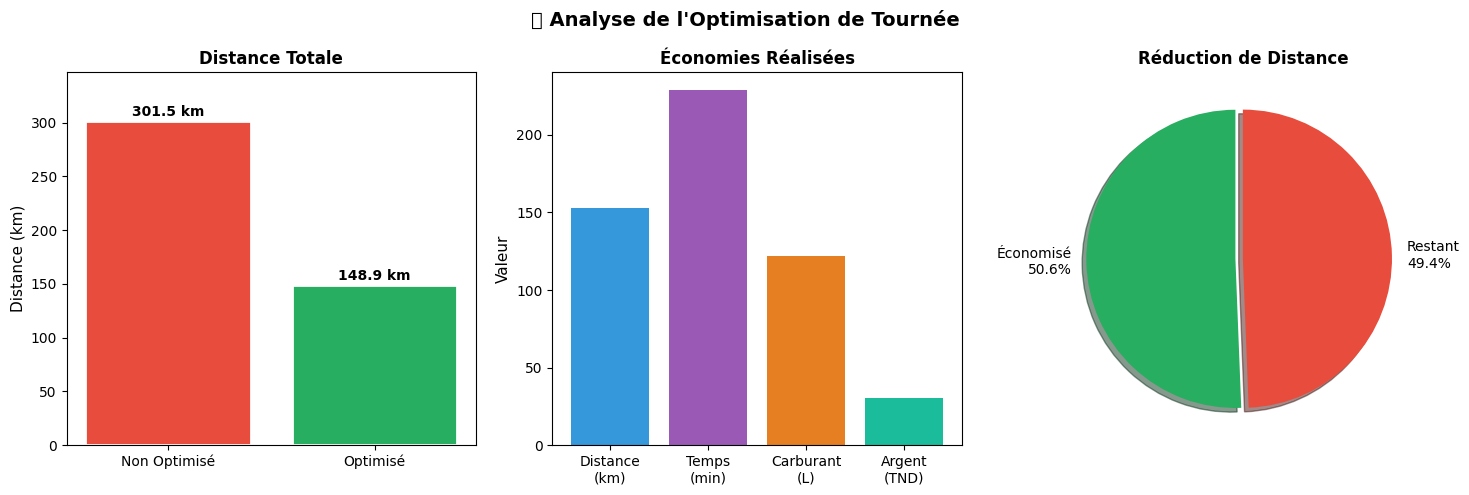

✅ Graphique sauvegardé: optimization_analysis.png


In [11]:
# =============================================================================
# 🎨 VISUALISATION GRAPHIQUE DES RÉSULTATS
# =============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('📊 Analyse de l\'Optimisation de Tournée', fontsize=14, fontweight='bold')

# Graphique 1: Comparaison distances
ax1 = axes[0]
categories = ['Non Optimisé', 'Optimisé']
distances = [comparison['non_optimized'], comparison['optimized']]
colors = ['#e74c3c', '#27ae60']
bars = ax1.bar(categories, distances, color=colors, edgecolor='white', linewidth=2)
ax1.set_ylabel('Distance (km)', fontsize=11)
ax1.set_title('Distance Totale', fontsize=12, fontweight='bold')
for bar, dist in zip(bars, distances):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{dist:.1f} km', ha='center', fontsize=10, fontweight='bold')
ax1.set_ylim(0, max(distances) * 1.15)

# Graphique 2: Économies
ax2 = axes[1]
savings_data = {
    'Distance\n(km)': comparison['savings_km'],
    'Temps\n(min)': comparison['time_saved_min'],
    'Carburant\n(L)': comparison['fuel_saved_l'] * 10,  # Scale for visibility
    'Argent\n(TND)': comparison['money_saved_tnd']
}
colors2 = ['#3498db', '#9b59b6', '#e67e22', '#1abc9c']
bars2 = ax2.bar(savings_data.keys(), savings_data.values(), color=colors2)
ax2.set_title('Économies Réalisées', fontsize=12, fontweight='bold')
ax2.set_ylabel('Valeur', fontsize=11)

# Graphique 3: Répartition de la réduction
ax3 = axes[2]
sizes = [comparison['savings_pct'], 100 - comparison['savings_pct']]
labels = [f'Économisé\n{comparison["savings_pct"]:.1f}%', f'Restant\n{100-comparison["savings_pct"]:.1f}%']
colors3 = ['#27ae60', '#e74c3c']
explode = (0.05, 0)
ax3.pie(sizes, explode=explode, labels=labels, colors=colors3, autopct='',
        shadow=True, startangle=90)
ax3.set_title('Réduction de Distance', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('optimization_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Graphique sauvegardé: optimization_analysis.png")

In [1]:
import requests
import polyline

# =============================================================================
# 🚀 VERSION AMÉLIORÉE AVEC OSRM LOCAL - ROUTAGE ROUTIER RÉEL
# =============================================================================
# Cette version utilise OSRM pour obtenir les VRAIES routes, pas des lignes droites

class OSRMRealRouter:
    """
    Routeur utilisant OSRM local pour des routes 100% réelles.
    Respecte les sens uniques, les intersections, et les routes réelles.
    """
    
    def __init__(self, osrm_url="http://localhost:5000"):
        self.osrm_url = osrm_url
        self.cache = {}
        self.route_cache = {}  # Cache pour les géométries de routes
        
    def check_connection(self):
        """Vérifie la connexion à OSRM"""
        try:
            r = requests.get(f"{self.osrm_url}/route/v1/driving/10.6,34.95;10.61,34.96", timeout=5)
            if r.status_code == 200:
                data = r.json()
                if data.get('code') == 'Ok':
                    print("✅ OSRM local connecté et fonctionnel!")
                    return True
        except Exception as e:
            print(f"❌ OSRM non disponible: {e}")
        return False
    
    def get_real_route(self, origin, destination):
        """
        Obtient la route RÉELLE entre deux points via OSRM.
        Retourne: (distance_km, duration_sec, geometry_coords)
        """
        cache_key = f"{origin}_{destination}"
        if cache_key in self.route_cache:
            return self.route_cache[cache_key]
        
        lat1, lon1 = origin
        lat2, lon2 = destination
        
        try:
            url = f"{self.osrm_url}/route/v1/driving/{lon1},{lat1};{lon2},{lat2}"
            url += "?overview=full&geometries=geojson&steps=true"
            
            r = requests.get(url, timeout=10)
            data = r.json()
            
            if data.get('code') == 'Ok':
                route = data['routes'][0]
                distance = route['distance'] / 1000  # m → km
                duration = route['duration']  # secondes
                
                # Extraire la géométrie complète (points de la route)
                coords = [(p[1], p[0]) for p in route['geometry']['coordinates']]
                
                result = {
                    'distance': distance,
                    'duration': duration,
                    'geometry': coords,
                    'steps': route.get('legs', [{}])[0].get('steps', [])
                }
                self.route_cache[cache_key] = result
                return result
        except Exception as e:
            print(f"⚠️ Erreur OSRM pour {origin} → {destination}: {e}")
        
        return None
    
    def get_distance_matrix_osrm(self, locations):
        """
        Calcule la matrice des distances RÉELLES via OSRM Table API.
        Beaucoup plus rapide que des requêtes individuelles.
        """
        n = len(locations)
        
        # Construire la requête OSRM Table
        coords_str = ";".join([f"{loc[1]},{loc[0]}" for loc in locations])
        url = f"{self.osrm_url}/table/v1/driving/{coords_str}"
        url += "?annotations=distance,duration"
        
        try:
            r = requests.get(url, timeout=60)
            data = r.json()
            
            if data.get('code') == 'Ok':
                distances = np.array(data['distances']) / 1000  # m → km
                durations = np.array(data['durations']) / 60    # s → min
                
                print(f"✅ Matrice {n}x{n} calculée via OSRM (routes réelles)")
                return distances, durations
        except Exception as e:
            print(f"❌ Erreur matrice OSRM: {e}")
        
        return None, None

# Test de connexion OSRM
print("🔍 Test de connexion à OSRM local...")
osrm_router = OSRMRealRouter()
osrm_available = osrm_router.check_connection()

if not osrm_available:
    print()
    print("⚠️ OSRM n'est pas encore lancé. Exécutez ces commandes dans un terminal:")
    print()
    print("   cd C:\\Users\\USER\\Desktop\\Nouveau dossier (2)\\osrm-data")
    print()
    print("   # Étape 1: Extraction (déjà en cours)")
    print("   docker run -t -v \"C:/Users/USER/Desktop/Nouveau dossier (2)/osrm-data:/data\" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/tunisia-latest.osm.pbf")
    print()
    print("   # Étape 2: Partition")
    print("   docker run -t -v \"C:/Users/USER/Desktop/Nouveau dossier (2)/osrm-data:/data\" osrm/osrm-backend osrm-partition /data/tunisia-latest.osrm")
    print()
    print("   # Étape 3: Customisation")
    print("   docker run -t -v \"C:/Users/USER/Desktop/Nouveau dossier (2)/osrm-data:/data\" osrm/osrm-backend osrm-customize /data/tunisia-latest.osrm")
    print()
    print("   # Étape 4: Lancer le serveur")
    print("   docker run -t -p 5000:5000 -v \"C:/Users/USER/Desktop/Nouveau dossier (2)/osrm-data:/data\" osrm/osrm-backend osrm-routed --algorithm mld /data/tunisia-latest.osrm")

🔍 Test de connexion à OSRM local...
✅ OSRM local connecté et fonctionnel!


In [2]:
# =============================================================================
# 🎯 OPTIMISEUR VRP AMÉLIORÉ AVEC ROUTES RÉELLES
# =============================================================================

class EnhancedVRPOptimizer:
    """
    Optimiseur VRP amélioré utilisant OSRM pour les distances réelles.
    Inclut des heuristiques avancées pour de meilleures performances.
    """
    
    def __init__(self, osrm_router):
        self.osrm = osrm_router
    
    def solve_with_real_routes(self, depot, clients, client_ids=None):
        """
        Résout le VRP avec des routes réelles via OSRM.
        """
        if len(clients) == 0:
            return {"error": "Aucun client"}
        
        # Construire la liste des locations
        all_locations = [depot] + list(clients)
        n = len(all_locations)
        
        print(f"📊 Calcul de la matrice des distances réelles ({n}x{n})...")
        
        # Obtenir la matrice via OSRM
        dist_matrix, time_matrix = self.osrm.get_distance_matrix_osrm(all_locations)
        
        if dist_matrix is None:
            print("⚠️ OSRM non disponible, utilisation du fallback géodésique")
            return None
        
        # Convertir en entiers pour OR-Tools
        int_matrix = (dist_matrix * 1000).astype(int).tolist()
        
        # Créer le modèle
        manager = pywrapcp.RoutingIndexManager(n, 1, 0)
        routing = pywrapcp.RoutingModel(manager)
        
        def distance_callback(from_index, to_index):
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return int_matrix[from_node][to_node]
        
        transit_callback_index = routing.RegisterTransitCallback(distance_callback)
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
        
        # Paramètres de recherche optimisés
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        
        if n <= 15:
            # Recherche plus exhaustive pour petits problèmes
            search_parameters.first_solution_strategy = (
                routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC
            )
            search_parameters.local_search_metaheuristic = (
                routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
            )
            search_parameters.time_limit.seconds = 60
        else:
            # Heuristique rapide pour grands problèmes
            search_parameters.first_solution_strategy = (
                routing_enums_pb2.FirstSolutionStrategy.SAVINGS
            )
            search_parameters.local_search_metaheuristic = (
                routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING
            )
            search_parameters.time_limit.seconds = 30
        
        print("🔄 Optimisation en cours (routes réelles)...")
        solution = routing.SolveWithParameters(search_parameters)
        
        if solution:
            # Extraire la route
            route = []
            index = routing.Start(0)
            while not routing.IsEnd(index):
                node = manager.IndexToNode(index)
                if node != 0:
                    route.append(node - 1)
                index = solution.Value(routing.NextVar(index))
            
            total_distance = solution.ObjectiveValue() / 1000
            
            # Calculer le temps total
            total_time = 0
            for i in range(len(route)):
                if i == 0:
                    total_time += time_matrix[0][route[i] + 1]
                else:
                    total_time += time_matrix[route[i-1] + 1][route[i] + 1]
            total_time += time_matrix[route[-1] + 1][0]  # Retour
            
            result = {
                "order": route,
                "client_ids": [client_ids[i] for i in route] if client_ids else route,
                "total_distance": total_distance,
                "total_time_min": total_time,
                "algorithm": "OR-Tools + OSRM (Routes Réelles)",
                "num_clients": len(clients),
                "distance_matrix": dist_matrix,
                "time_matrix": time_matrix
            }
            
            print(f"✅ Optimisation terminée!")
            print(f"📏 Distance totale: {total_distance:.2f} km")
            print(f"⏱️  Temps estimé: {total_time:.0f} min")
            
            return result
        
        return {"error": "Aucune solution trouvée"}

# Créer l'optimiseur amélioré
enhanced_optimizer = EnhancedVRPOptimizer(osrm_router)
print("✅ Optimiseur VRP amélioré initialisé")

✅ Optimiseur VRP amélioré initialisé


In [3]:
# =============================================================================
# 🗺️ CARTE AMÉLIORÉE AVEC ROUTES RÉELLES (PAS DE LIGNES DROITES)
# =============================================================================

class RealRouteMapGenerator:
    """
    Génère une carte avec les VRAIES routes routières, pas des lignes droites.
    """
    
    def __init__(self, osrm_router):
        self.osrm = osrm_router
        self.colors = {
            'depot': '#2E86AB',
            'client': '#E94F37', 
            'route': '#1B998B',
            'route_alt': '#FF6B35'
        }
    
    def create_real_route_map(self, depot, clients_df, route_order, result):
        """
        Crée une carte avec les routes réelles tracées sur les vraies routes.
        """
        # Créer la carte
        center_lat = clients_df['lat'].mean()
        center_lon = clients_df['lon'].mean()
        
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=12,
            tiles='OpenStreetMap'
        )
        
        # Ajouter couche satellite optionnelle
        folium.TileLayer(
            'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr='Esri',
            name='Satellite'
        ).add_to(m)
        
        folium.TileLayer('cartodbpositron', name='Clair').add_to(m)
        
        # Groupe pour les routes
        route_group = folium.FeatureGroup(name='🛣️ Route Réelle')
        
        # Construire les points dans l'ordre
        ordered_clients = [clients_df.iloc[i] for i in route_order]
        
        # Tracer les routes réelles segment par segment
        all_route_points = []
        current_pos = depot
        
        print("🗺️ Récupération des routes réelles via OSRM...")
        
        for i, client in enumerate(ordered_clients):
            client_pos = (client['lat'], client['lon'])
            
            # Obtenir la route réelle
            route_data = self.osrm.get_real_route(current_pos, client_pos)
            
            if route_data:
                # Ajouter les points de la route réelle
                route_coords = route_data['geometry']
                all_route_points.extend(route_coords)
                
                # Tracer ce segment avec une couleur dégradée
                folium.PolyLine(
                    locations=route_coords,
                    color=self.colors['route'],
                    weight=5,
                    opacity=0.8,
                    tooltip=f"Segment {i}: {route_data['distance']:.1f} km"
                ).add_to(route_group)
            
            current_pos = client_pos
        
        # Route de retour au dépôt
        route_data = self.osrm.get_real_route(current_pos, depot)
        if route_data:
            folium.PolyLine(
                locations=route_data['geometry'],
                color=self.colors['route_alt'],
                weight=4,
                opacity=0.7,
                dash_array='10',
                tooltip=f"Retour dépôt: {route_data['distance']:.1f} km"
            ).add_to(route_group)
        
        route_group.add_to(m)
        
        # Ajouter marqueur du dépôt
        depot_icon = folium.DivIcon(
            html=f'''
            <div style="
                background: {self.colors['depot']};
                width: 45px; height: 45px;
                border-radius: 50%;
                border: 4px solid white;
                box-shadow: 0 3px 15px rgba(0,0,0,0.4);
                display: flex;
                align-items: center;
                justify-content: center;
                font-size: 22px;
            ">🚚</div>
            ''',
            icon_size=(45, 45),
            icon_anchor=(22, 22)
        )
        
        folium.Marker(
            location=depot,
            icon=depot_icon,
            popup=f'''
            <div style="font-family: Arial; padding: 10px;">
                <h3 style="color: {self.colors['depot']};">🚚 Dépôt / Livreur</h3>
                <p><b>Position:</b> {depot[0]:.6f}, {depot[1]:.6f}</p>
                <hr>
                <p><b>Distance totale:</b> {result['total_distance']:.2f} km</p>
                <p><b>Temps estimé:</b> {result.get('total_time_min', 0):.0f} min</p>
            </div>
            ''',
            tooltip="🚚 Dépôt - Départ/Arrivée"
        ).add_to(m)
        
        # Ajouter marqueurs des clients
        for i, client_idx in enumerate(route_order, 1):
            client = clients_df.iloc[client_idx]
            
            client_icon = folium.DivIcon(
                html=f'''
                <div style="
                    background: {self.colors['client']};
                    width: 32px; height: 32px;
                    border-radius: 50%;
                    border: 3px solid white;
                    box-shadow: 0 2px 10px rgba(0,0,0,0.3);
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    font-size: 13px;
                    font-weight: bold;
                    color: white;
                ">{i}</div>
                ''',
                icon_size=(32, 32),
                icon_anchor=(16, 16)
            )
            
            folium.Marker(
                location=[client['lat'], client['lon']],
                icon=client_icon,
                popup=f'''
                <div style="font-family: Arial; padding: 10px; min-width: 180px;">
                    <h3 style="color: {self.colors['client']};">📦 Stop #{i}</h3>
                    <p><b>Commande:</b> {client['order_id']}</p>
                    <p><b>Position:</b> {client['lat']:.6f}, {client['lon']:.6f}</p>
                </div>
                ''',
                tooltip=f"📦 #{i} - {client['order_id']}"
            ).add_to(m)
        
        # Ajouter contrôle des couches
        folium.LayerControl().add_to(m)
        
        # Statistiques
        stats_html = f'''
        <div style="
            position: fixed;
            top: 10px; right: 10px;
            background: linear-gradient(135deg, #1a237e 0%, #0d47a1 100%);
            color: white;
            padding: 20px;
            border-radius: 12px;
            box-shadow: 0 4px 20px rgba(0,0,0,0.3);
            font-family: Arial;
            z-index: 1000;
            min-width: 220px;
        ">
            <h3 style="margin: 0 0 15px 0; font-size: 16px;">
                🗺️ Trajet Optimisé (Routes Réelles)
            </h3>
            <div style="margin: 8px 0;">
                <span style="opacity: 0.8;">📦 Clients:</span>
                <b style="float: right;">{result['num_clients']}</b>
            </div>
            <div style="margin: 8px 0;">
                <span style="opacity: 0.8;">📏 Distance:</span>
                <b style="float: right;">{result['total_distance']:.2f} km</b>
            </div>
            <div style="margin: 8px 0;">
                <span style="opacity: 0.8;">⏱️ Temps:</span>
                <b style="float: right;">{result.get('total_time_min', 0):.0f} min</b>
            </div>
            <div style="margin: 8px 0;">
                <span style="opacity: 0.8;">🎯 Algorithme:</span>
                <b style="float: right; font-size: 11px;">OSRM + OR-Tools</b>
            </div>
            <hr style="border-color: rgba(255,255,255,0.2); margin: 15px 0;">
            <div style="font-size: 11px; opacity: 0.7;">
                ✅ Routes routières réelles<br>
                ✅ Sens uniques respectés<br>
                ✅ Intersections gérées
            </div>
        </div>
        '''
        m.get_root().html.add_child(folium.Element(stats_html))
        
        # Ajuster la vue
        all_points = [depot] + [(c['lat'], c['lon']) for _, c in clients_df.iloc[route_order].iterrows()]
        m.fit_bounds(all_points)
        
        return m

# Initialiser le générateur de carte amélioré
real_map_generator = RealRouteMapGenerator(osrm_router)
print("✅ Générateur de carte avec routes réelles initialisé")

✅ Générateur de carte avec routes réelles initialisé


In [8]:
# =============================================================================
# 🚀 EXÉCUTION AVEC OSRM - ROUTES RÉELLES
# =============================================================================
# Ce code s'exécute une fois OSRM lancé

def run_with_real_routes():
    """
    Exécute l'optimisation complète avec OSRM pour les routes réelles.
    """
    # Vérifier OSRM
    if not osrm_router.check_connection():
        print("❌ OSRM n'est pas disponible!")
        print()
        print("🔧 Lancez OSRM avec cette commande:")
        print('   docker run -t -p 5000:5000 -v "C:/Users/USER/Desktop/Nouveau dossier (2)/osrm-data:/data" osrm/osrm-backend osrm-routed --algorithm mld /data/tunisia-latest.osrm')
        return None
    
    print("="*60)
    print("🚀 OPTIMISATION AVEC ROUTES RÉELLES (OSRM)")
    print("="*60)
    print()
    
    # Position du livreur
    depot = DEPOT_POSITION
    print(f"📍 Position livreur: {depot}")
    
    # Sélectionner les clients (utiliser les mêmes que la démo)
    clients_coords = [(df_clients.iloc[i]['lat'], df_clients.iloc[i]['lon']) 
                      for i in selected_indices]
    client_ids = [df_clients.iloc[i]['order_id'] for i in selected_indices]
    
    print(f"📦 Clients à livrer: {len(clients_coords)}")
    print()
    
    # Optimiser avec routes réelles
    result = enhanced_optimizer.solve_with_real_routes(depot, clients_coords, client_ids)
    
    if result and 'order' in result:
        print()
        print("📋 Ordre optimal de livraison:")
        print("-"*40)
        for i, client_id in enumerate(result['client_ids'], 1):
            client_data = df_clients[df_clients['order_id'] == client_id].iloc[0]
            print(f"   {i:2d}. {client_id}")
        print("-"*40)
        
        # Créer la carte avec routes réelles
        print()
        print("🗺️ Génération de la carte avec routes réelles...")
        
        # Mapper les indices
        idx_map = {df_clients.iloc[selected_indices[i]].name: i 
                   for i in range(len(selected_indices))}
        
        real_map = real_map_generator.create_real_route_map(
            depot=depot,
            clients_df=df_clients.iloc[selected_indices].reset_index(drop=True),
            route_order=result['order'],
            result=result
        )
        
        # Sauvegarder
        real_map.save('real_route_map.html')
        print(f"✅ Carte sauvegardée: real_route_map.html")
        
        return result, real_map
    
    return None, None

# Essayer d'exécuter avec OSRM
print("🔍 Tentative de connexion à OSRM...")
if osrm_router.check_connection():
    result_real, map_real = run_with_real_routes()
    if map_real:
        display(map_real)
else:
    print()
    print("⏳ OSRM en cours de préparation...")
    print("   Une fois les étapes Docker terminées, relancez cette cellule.")

🔍 Tentative de connexion à OSRM...
✅ OSRM local connecté et fonctionnel!
✅ OSRM local connecté et fonctionnel!
🚀 OPTIMISATION AVEC ROUTES RÉELLES (OSRM)

📍 Position livreur: (34.7406, 10.7603)
📦 Clients à livrer: 15

📊 Calcul de la matrice des distances réelles (16x16)...
✅ Matrice 16x16 calculée via OSRM (routes réelles)
🔄 Optimisation en cours (routes réelles)...
✅ Optimisation terminée!
📏 Distance totale: 187.35 km
⏱️  Temps estimé: 286 min

📋 Ordre optimal de livraison:
----------------------------------------
    1. ORDJ08758
    2. ORDI01160
    3. ORDJ02766
    4. ORDC06134
    5. ORDZ04094
    6. ORDI05711
    7. ORDC01406
    8. ORDJ08294
    9. ORDJ10488
   10. ORDA00121
   11. ORDX11029
   12. ORDX03673
   13. ORDB08870
   14. ORDK06915
   15. ORDA10444
----------------------------------------

🗺️ Génération de la carte avec routes réelles...
🗺️ Récupération des routes réelles via OSRM...
✅ Carte sauvegardée: real_route_map.html
